#<center> $\Psi$(y,Z) remapped from T-space </center> #

* **Psi** = remapped stream function:
  $\psi$(y,T(y,z)) put in terms of $\psi(y,Z)$
  This uses a linear interpolation to match grids and temperature bands
  
* **Psi Ed** = Eddy stream function
  $\psi_{eddy}=\psi_{res}(y,Z)-\overline{\psi(y,Z)}$
  
* **K** = Eddy diffusivity
  $K=-\psi_{eddy}\frac{\overline{b_z}}{\overline{b_y}}$
  As from GM90 eddy parameterisation the eddy circulation can be thought of as this diffusivity multipied by isopycnal slope
  
Script overview:

1. Chose one of the above pannels to plot

2. Give it the file pattern (i.e. Where to search and what years do I want!). Do you want all runs possible? (pick Y or N)

3. Load in modules

4. Now before starting best to load in constant Variables such as grid parameters and constants.

5. Go into the main loop that's gonna read in the layers package data, calcuate the RMOC and then read in the temp field and find the depths of those temperatures and replot. Then calculate K and Eddy overturning. 

In [2]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [3]:
# Load in Modules
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from Full_channel import *
from HB_Plot import nf, fmt
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Full'


# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Depth = file2.variables['Depth'][:]
Yc = file2.variables['Y'][:]
msk = file2.variables['HFacS'][:]
lmsk = msk.mean(axis=2)
lmsk[lmsk==0]=np.nan
lmsk[~np.isnan(lmsk)] = 1
Zmatrix = np.zeros((len(Z), len(Y)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dzc = Z[0:len(Z)-1]-Z[1:len(Z)]
ny = len(Y)
nz = len(Z)

\begin{equation}
Q(y)=
\begin{cases}
-Q_{0}\,cos(\frac{18\pi y}{5Ly}) & \text{for }\, y \le \frac{5Ly}{36} \text{ and } \frac{22Ly}{36} \geq y \geq \frac{30Ly}{36},\\
-Q_{0}\,cos(\frac{18 \pi y}{5Ly}-\frac{\pi}{2}) & \text{for }\, \frac{5Ly}{36} \geq y \geq \frac{20Ly}{36},\\
0 & \text{for }\, y \geq \frac{5Ly}{6},
\end{cases}
\end{equation}

In [4]:
# Surface Heat Fluxes
Ly = 2000e3
Lx = 1000e3
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q=np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))

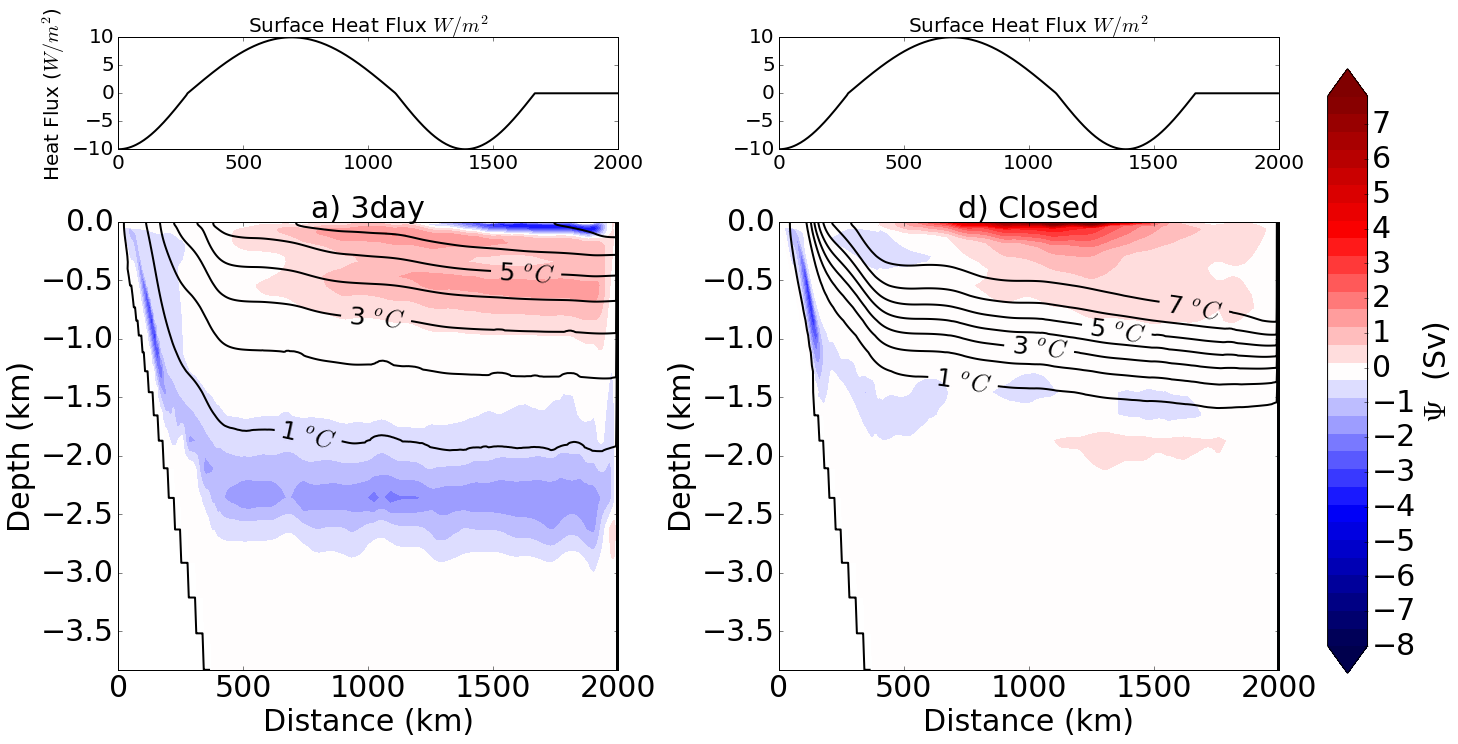

In [12]:
fig = plt.figure(figsize=(18.5, 10.5))
# Plot Heat Flux on top
if Qplot == 'Y':
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
# Create Panels
Psi_levs = np.arange(-8., 8., .51)
Psi_ticks =np.arange(-8., 8., 1.)
Eddy_ticks = (np.arange(-20, 1, 4.))
E_levs = np.arange(-20., 1, 2.)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:].mean(axis=0)
    th = file2read.variables["LaHs1TH"][:].mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    A = x+'/'+str(tau[Runs[i]])+'/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    psiz = get_psi_isoz_full(lvrho,th,Depth,Z)
    # Mean Overturning for Eddy Streamfuction
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V*msk, axis=0)
    #Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave, axis=2)*dx
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi_m = np.cumsum(-psi2[::-1, :], axis=0)[::-1,:]
    psi_m[psi_m==0]=np.nan
    npad = ((0, 1), (0, 0))
    psi_m = np.pad(psi_m, pad_width=npad, mode='constant', constant_values=0)
    # Eddy
    Psied = psiz - numba_regridz(psi_m)/10**6
    # PLOT PANNELS
    if Full != 'Y' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full != 'Y' and Qplot == 'N':
        ax = fig.add_subplot(1, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,8,1))
    if VAR == 'PsiEd':
        p = ax.contourf(Y/1000, Z/1000,
                        Psied, E_levs, cmap=plt.cm.Blues_r)
    else:
        p = ax.contourf(Y/1000, Z/1000,
                psiz*lmsk, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
if VAR == 'K':
    cbar = fig.colorbar(p, cax=cax, ticks=K_ticks)
    cbar.ax.set_ylabel('$\Psi \,\, (sv)$', fontsize=20)
    cbar.ax.tick_params(labelsize=30)
elif VAR == 'PsiEd':
    cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
    cbar.ax.set_ylabel('$\Psi $ (Sv)', fontsize=30)
    cbar.ax.tick_params(labelsize=30)
else:
    cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
    cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
    cbar.ax.tick_params(labelsize=30)